# Scout Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from utils import *

In [7]:
scout_df = pd.read_csv('data/scout/processed_results.csv')
scout_df.head(10)

one_hop_df = scout_df[scout_df['hop2_reduction'].isna()]
two_hop_df = scout_df[scout_df['hop2_reduction'].notna()]

exhaustive_search_time = one_hop_df.hop1_time.sum() + two_hop_df.hop2_time.sum()
print('Exhaustive search time: {}'.format(exhaustive_search_time))

Exhaustive search time: 69506.0


In [8]:
scout_df.head()

,hop1_reduction,hop1_time,hop2_reduction,hop2_time,eval_time,keep_frac,acc,f1
0,Agg_GB0_1,257,NaN,NaN,263,0.063705,0.880546,0.881356
1,Agg_GB0_2,259,NaN,NaN,356,0.086151,0.889078,0.890017
2,Agg_GB0_3,266,NaN,NaN,536,0.131043,0.883959,0.885522
3,Agg_GB1_1,197,NaN,NaN,126,0.047487,0.883959,0.884746
4,Agg_GB1_2,194,NaN,NaN,164,0.064268,0.885666,0.886633


## One-hop reduction

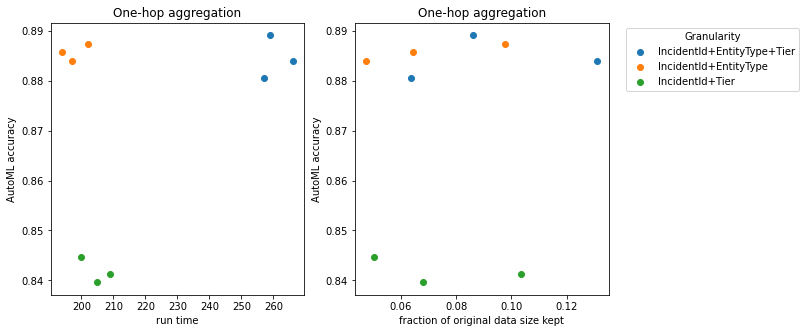

In [9]:
# one-hop aggregations
agg_df = one_hop_df[one_hop_df['hop1_reduction'].str.startswith('Agg')]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

gb_num_to_names = {
    0: 'IncidentId+EntityType+Tier',
    1: 'IncidentId+EntityType',
    2: 'IncidentId+Tier'
}

for gb_num in [0, 1, 2]:
    sub_agg_df = agg_df[agg_df.hop1_reduction.str.contains('GB{}'.format(gb_num))]
    axs[0].scatter(sub_agg_df.hop1_time, sub_agg_df.acc, label=gb_num_to_names[gb_num])
    axs[1].scatter(sub_agg_df.keep_frac, sub_agg_df.acc, label=gb_num_to_names[gb_num])

axs[0].set_xlabel('run time')
axs[0].set_ylabel('AutoML accuracy')
# axs[0].legend(title='Aggregation criteria')
axs[0].set_title('One-hop aggregation')

axs[1].set_xlabel('fraction of original data size kept')
axs[1].set_ylabel('AutoML accuracy')
axs[1].legend(title='Granularity', bbox_to_anchor=(1.05, 1))
axs[1].set_title('One-hop aggregation')
plt.show()

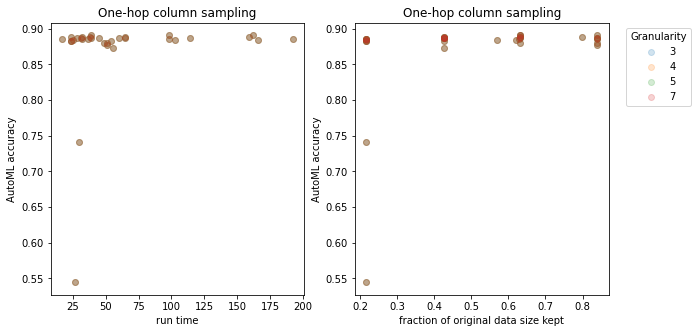

In [10]:
# one hop column sampling
col_df = one_hop_df[one_hop_df['hop1_reduction'].str.startswith('Col')]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

all_col_algos = col_df.hop1_reduction.unique()
all_col_GBs = sorted(list(set([x.split("_")[1] for x in all_col_algos])))

for gb in all_col_GBs:
    sub_col_df = col_df[col_df.hop1_reduction.str.contains(gb)]
    axs[0].scatter(col_df.hop1_time, col_df.acc, label=int(gb.replace("GB", "")), alpha=0.2)
    axs[1].scatter(col_df.keep_frac, col_df.acc, label=int(gb.replace("GB", "")), alpha=0.2)

axs[0].set_xlabel('run time')
axs[0].set_ylabel('AutoML accuracy')
axs[0].set_title('One-hop column sampling')
#axs[0].set_ylim(0.85, 0.91)

axs[1].set_xlabel('fraction of original data size kept')
axs[1].set_ylabel('AutoML accuracy')
axs[1].set_title('One-hop column sampling')
#axs[1].set_ylim(0.85, 0.91)
axs[1].legend(title='Granularity', bbox_to_anchor=(1.05, 1))
plt.show()

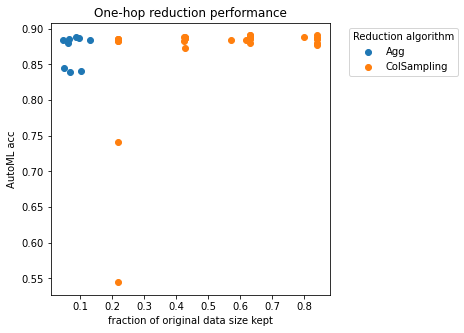

In [11]:
# Greedy algorithm selection metric
# Hop 1

plt.figure(figsize=(5, 5))
algos = ['Agg', 'ColSampling']

for algo in algos:
    sub_df = one_hop_df[one_hop_df.hop1_reduction.str.startswith(algo)]
    plt.scatter(sub_df.keep_frac, sub_df.acc, label=algo)

plt.xlabel('fraction of original data size kept')
plt.ylabel('AutoML acc')

plt.legend(title='Reduction algorithm', bbox_to_anchor=(1.05, 1))
plt.title('One-hop reduction performance')
plt.show()

## Self-defined greedy selection metric

AutoML accuracy / fraction of original data kept after reduction

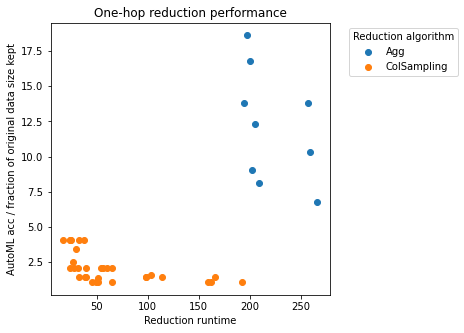

Greedy choice for first hop reduction is Agg_GB1_1


In [12]:
# self-defined metric: acc / keep_frac

plt.figure(figsize=(5, 5))
algos = ['Agg', 'ColSampling']

for algo in algos:
    sub_df = one_hop_df[one_hop_df.hop1_reduction.str.startswith(algo)]
    plt.scatter(sub_df.hop1_time, sub_df.acc / sub_df.keep_frac, label=algo)

plt.xlabel('Reduction runtime')
plt.ylabel('AutoML acc / fraction of original data size kept')

plt.legend(title='Reduction algorithm', bbox_to_anchor=(1.05, 1))
plt.title('One-hop reduction performance')
plt.show()

best_hop1_choice = one_hop_df.iloc[np.divide(one_hop_df.acc, one_hop_df.keep_frac).argmax()]['hop1_reduction']
print('Greedy choice for first hop reduction is {}'.format(best_hop1_choice))

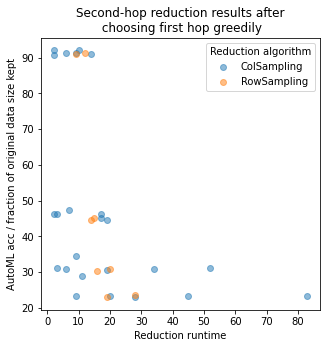

Greedy choice for second hop reduction is ColSampling_GB7_smf_col-0.2-fbs
greedy algorithm total runtime (for two hops): 4584.0


In [13]:
# self-defined metric: acc / keep_frac

selected_second_df = two_hop_df[two_hop_df['hop1_reduction'] == best_hop1_choice]
hop2_algos = set([x.split("_")[0] for x in selected_second_df.hop2_reduction.unique()])

plt.figure(figsize=(5, 5))

for algo in hop2_algos:
    sub_df = selected_second_df[selected_second_df.hop2_reduction.str.startswith(algo)]
    plt.scatter(sub_df.hop2_time, sub_df.acc / sub_df.keep_frac, label=algo, alpha=0.5)

hop2_selected_row = selected_second_df.iloc[
    np.divide(selected_second_df.acc, selected_second_df.keep_frac).argmax()
]

plt.xlabel('Reduction runtime')
plt.ylabel('AutoML acc / fraction of original data size kept')

plt.legend(title='Reduction algorithm')
plt.title('Second-hop reduction results after\n choosing first hop greedily')
plt.show()

best_hop2_choice = selected_second_df.iloc[
    np.divide(selected_second_df.acc, selected_second_df.keep_frac).argmax()
]['hop2_reduction']
print('Greedy choice for second hop reduction is {}'.format(best_hop2_choice))

hop1_total_time = one_hop_df.hop1_time.sum()
hop2_total_time = selected_second_df.hop2_time.sum()

greedy_total_time = hop1_total_time + hop2_total_time
print('greedy algorithm total runtime (for two hops): {}'.format(greedy_total_time))

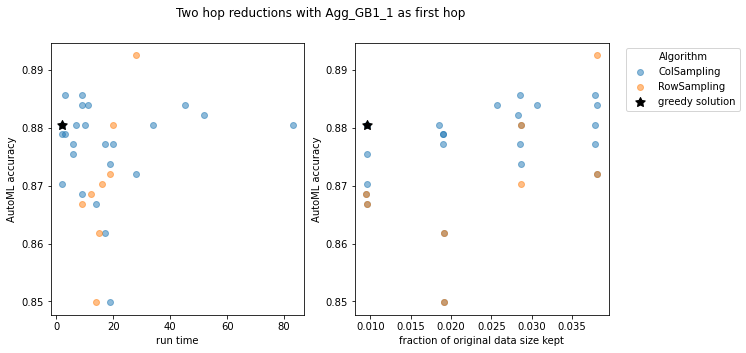

In [14]:
# replot after second hop is selected
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for algo in hop2_algos:
    sub_df = selected_second_df[selected_second_df.hop2_reduction.str.startswith(algo)]
    axs[0].scatter(sub_df.hop2_time, sub_df.acc, label=algo, alpha=0.5)
    axs[1].scatter(sub_df.keep_frac, sub_df.acc, label=algo, alpha=0.5)

selected_second_row = selected_second_df[selected_second_df.hop2_reduction == best_hop2_choice].iloc[0]
axs[0].scatter(selected_second_row['hop2_time'], selected_second_row['acc'], label='greedy solution', c='black',  marker=(5, 1), s=100)
axs[1].scatter(selected_second_row['keep_frac'], selected_second_row['acc'], label='greedy solution', c='black',  marker=(5, 1), s=100)

axs[0].set_xlabel('run time')
axs[0].set_ylabel('AutoML accuracy')

axs[1].set_xlabel('fraction of original data size kept')
axs[1].set_ylabel('AutoML accuracy')
axs[1].legend(title='Algorithm', bbox_to_anchor=(1.05, 1))

plt.suptitle('Two hop reductions with {} as first hop'.format(best_hop1_choice))
plt.show()

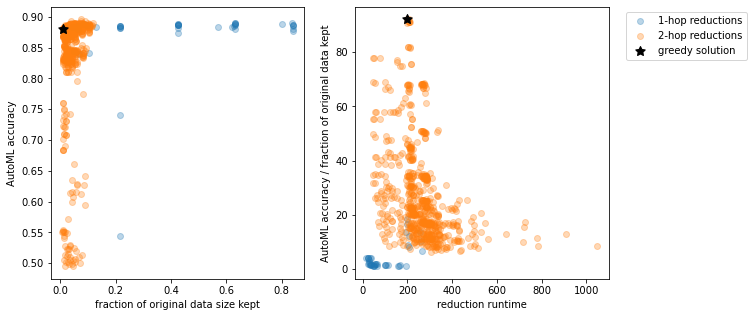

In [15]:
# Overall performance

one_hop_df.loc[:]['hop2_time'] = np.zeros(one_hop_df.shape[0])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for idx, hop_df in enumerate([one_hop_df, two_hop_df]):
    axs[0].scatter(hop_df.keep_frac, hop_df.acc, label="{}-hop reductions".format(idx + 1), alpha=0.3)
    axs[1].scatter(
        hop_df.hop1_time + hop_df.hop2_time, hop_df.acc / hop_df.keep_frac,
        label="{}-hop reductions".format(idx + 1),
        alpha=0.3
    )

# greedy picked solution
selected_row = scout_df[(scout_df.hop1_reduction == best_hop1_choice)&(scout_df.hop2_reduction == best_hop2_choice)].iloc[0]
axs[0].scatter(selected_row['keep_frac'], selected_row['acc'], label='greedy solution', c='black',  marker=(5, 1), s=100)
axs[1].scatter(
    selected_row['hop1_time'] + selected_row['hop2_time'],
    selected_row['acc'] / selected_row['keep_frac'],
    label='greedy solution',
    c='black',
    marker=(5, 1),
    s=100
)

axs[0].set_xlabel('fraction of original data size kept')
axs[0].set_ylabel('AutoML accuracy')

axs[1].set_xlabel('reduction runtime')
axs[1].set_ylabel('AutoML accuracy / fraction of original data kept')
axs[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [16]:
# get global best solution in terms of AutoML accuracy and self-defined metric
best_acc_row = scout_df.iloc[scout_df.acc.values.argmax()]
best_metric_row = scout_df.iloc[np.divide(scout_df.acc.values, scout_df.keep_frac).argmax()]

output = pd.DataFrame([best_acc_row, best_metric_row, selected_row])
output['metric_val'] = output['acc'] / output['keep_frac']
output

,hop1_reduction,hop1_time,hop2_reduction,hop2_time,eval_time,keep_frac,acc,f1,metric_val
538,ColSampling_GB4_smf_col-0.6-fbs,38,Agg_GB1_3,184.0,244,0.073994,0.895904,0.896785,12.107774
245,Agg_GB1_1,197,ColSampling_GB7_smf_col-0.2-fbs,2.0,32,0.009563,0.880546,0.880952,92.082414
245,Agg_GB1_1,197,ColSampling_GB7_smf_col-0.2-fbs,2.0,32,0.009563,0.880546,0.880952,92.082414


**Conclusion:** the search stucks in local maximum
- many first-hop reductions have good & similar AutoML accuracies; main differentiating factor is fraction of data kept after reduction
- `Agg_GB1_1` has the lowest fraction of data kept after reduction; resulting in follow-up hop-2 search stucked
- Search objective is dominated by the fraction of data kept

## Customize greedy search objectives

In [65]:
def apply_search(objective_function, candidate_size=1, title=None):
    """
    The objective function applies to each row of scout_df
    """
    scout_df = pd.read_csv('data/scout/processed_results.csv')
    scout_df['search_objective'] = scout_df.apply(lambda row: objective_function(row), axis=1)

    # perform first round of search
    one_hop_df = scout_df[scout_df['hop2_reduction'].isna()]
    two_hop_df = scout_df[scout_df['hop2_reduction'].notna()]
    
    one_hop_sorted_idx = np.argsort(one_hop_df.search_objective.values)[::-1][:min(candidate_size, one_hop_df.shape[0])]
    selected_first_hop_df = one_hop_df.iloc[one_hop_sorted_idx]
    selected_first_hop_algos = set(selected_first_hop_df.hop1_reduction.values)
    selected_second_hop_df = two_hop_df[two_hop_df.hop1_reduction.isin(selected_first_hop_algos)]

    greedy_select_row = selected_second_hop_df.iloc[selected_second_hop_df.search_objective.argmax()]

    # compute search runtime
    exhaustive_search_time = one_hop_df.hop1_time.sum() + two_hop_df.hop2_time.sum()
    greedy_search_time = one_hop_df.hop1_time.sum() + selected_second_hop_df.hop2_time.sum()

    global_best_objective_row = scout_df.iloc[scout_df.search_objective.values.argmax()]
    output_df = pd.DataFrame([greedy_select_row, global_best_objective_row])
    old_cols = list(output_df.columns)
    output_df['search_method'] = ['greedy', 'exhaustive']
    output_df['search_time'] = [greedy_search_time, exhaustive_search_time]
    output_df = output_df[['search_method', ] + old_cols + ['search_time', ]]

    # plot
    plt.figure(figsize=(5, 5))
    for idx, hop_df in enumerate([one_hop_df, two_hop_df]):
        plt.scatter(hop_df.keep_frac, hop_df.acc, label="{}-hop reductions".format(idx + 1), alpha=0.3)
    plt.scatter(greedy_select_row['keep_frac'], greedy_select_row['acc'], label='greedy solution', c='black',  marker=(5, 1), s=100)
    plt.xlabel('Fraction of original data kept')
    plt.ylabel('AutoML evaluation accuracy')
    plt.legend(loc='lower right')
    plt.xlim(0.0, 0.2)
    plt.ylim(0.85, 0.91)
    if title is not None:
        plt.title(title)

    return output_df

,search_method,hop1_reduction,hop1_time,hop2_reduction,hop2_time,eval_time,keep_frac,acc,f1,search_objective,search_time
682,greedy,ColSampling_GB5_smf_col-0.6-fbs,39,Agg_GB1_3,235.0,262,0.076151,0.889078,0.888889,0.889078,6330.0
538,exhaustive,ColSampling_GB4_smf_col-0.6-fbs,38,Agg_GB1_3,184.0,244,0.073994,0.895904,0.896785,0.895904,69506.0


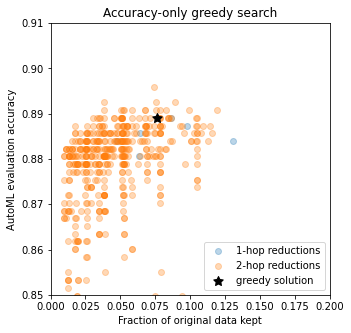

In [66]:
def accuracy_focused(red):
    return red['acc']

apply_search(accuracy_focused, title="Accuracy-only greedy search")

,search_method,hop1_reduction,hop1_time,hop2_reduction,hop2_time,eval_time,keep_frac,acc,f1,search_objective,search_time
134,greedy,Agg_GB0_2,259,ColSampling_GB7_smf_col-0.6-fls,5.0,280,0.051720,0.890785,0.890785,4.453925,7830.0
538,exhaustive,ColSampling_GB4_smf_col-0.6-fbs,38,Agg_GB1_3,184.0,244,0.073994,0.895904,0.896785,4.479522,69506.0


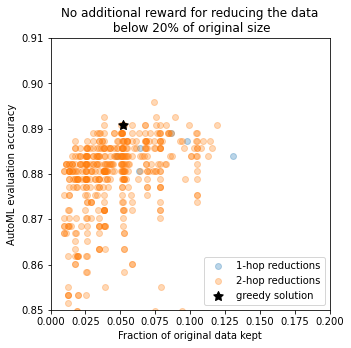

In [68]:
def keep_less_than_twenty_no_additional_benefit(red):
    return red['acc']/max(0.2, red['keep_frac'])

apply_search(keep_less_than_twenty_no_additional_benefit, title="No additional reward for reducing the data\n below 20% of original size")

,search_method,hop1_reduction,hop1_time,hop2_reduction,hop2_time,eval_time,keep_frac,acc,f1,search_objective,search_time
544,greedy,ColSampling_GB4_smf_col-0.6-fls,98,Agg_GB0_3,294.0,459,0.082408,0.890785,0.891156,0.890785,11188.0
538,exhaustive,ColSampling_GB4_smf_col-0.6-fbs,38,Agg_GB1_3,184.0,244,0.073994,0.895904,0.896785,0.895904,69506.0


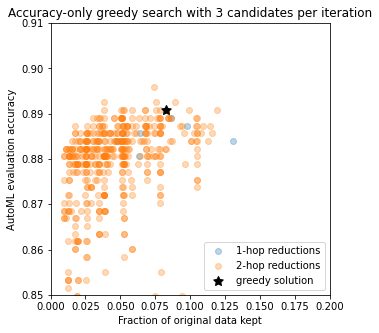

In [70]:
# increase number of search candidates per iteration

apply_search(accuracy_focused, candidate_size=3, title="Accuracy-only greedy search with 3 candidates per iteration")